# GECCO2019 - Bi-objective Traveling Thief Problem 

This worksheet contains the evaluation for the competition at GECCO2019. 

After having received all submissions, the evaluation will be done as follows:

For each of the nine test problems

1. We merged the solution sets of all submissions and extract the non-dominated set.
2. The minimum in time and the maximum in profit will be used to determine the reference point. With respect to this reference point the quality of each submission will be measured using the hypervolume indicator.

3. We will sort the submissions according to the achieved hypervolume in descending order and give points as follows: 1st place -> 3 points, 2nd place -> 2 points, 3rd place -> 1 point.

By adding up the points for each submission we will create the overall ranking. Please note, that depending on the number of submissions the evaluation might need to be reconsidered.

The validation has already been done using the Java code. Which means that each submission has the correct number of solutions (less than the maximum specfied at the competition homepage).


## Imports necessary for the evaluation

In [1]:
from non_dominated_sorting import fast_non_dominated_sort
import os.path
import numpy as np
import matplotlib.pyplot as plt
from hv import Hypervolume
from normalization import normalize
import pandas as pd

## Participants and Problems

In [2]:
# the result folder as a path
folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "submissions")

# all submissions received
participants = ["ALLAOUI","jomar", "shisunzhang", "ValAurTeam", "faria", "HPI", "SuperNatural"]


# all the problems to be solved
problems = ["a280_n279", "a280_n1395", "a280_n2790",
            "fnl4461_n4460", "fnl4461_n22300", "fnl4461_n44600", 
            "pla33810_n33809", "pla33810_n169045", "pla33810_n338090"
]


## Loading all the data

Load all the data from the results directory and convert it to a minimization problem.
The data dictionary containts all submissions of a partipant. The set of non-dominated points
is converted to a minimization problem by multiplying the profit times -1.

In [4]:

data = {}

for problem in problems[:6]:
    _entry = {}
    for participant in participants:
        
        # check for the corresponding file
        fname = "%s_%s.f" % (participant, problem)   
        path_to_file = os.path.join(folder,participant, fname)
        
        # in case the wrong delimiter was used
        if not os.path.isfile(path_to_file):
            fname = "%s_%s.f" % (participant, problem.replace("_", "-"))
            path_to_file = os.path.join(folder,participant, fname)
         
        # load the values in the objective space - first column is time, second profit
        _F = np.loadtxt(path_to_file)
        
        # modify it to a min-min problem by multiplying the profit by -1
        _entry[participant] = _F * [1, -1]
        
    data[problem] = _entry




## Plot the results

To have an idea how the submissions look like, we were plotting the results first.

Because the ranges of submissions might vary tremendously, for some problems visually no different can be seen.
Also, note that the plots are not normalized yet and the ranges are pretty large.

Plot the results. If points not shown there are not in the non-dominated region.
a280_n279


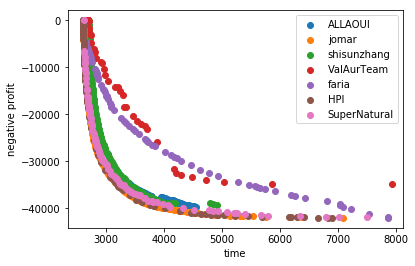

a280_n1395


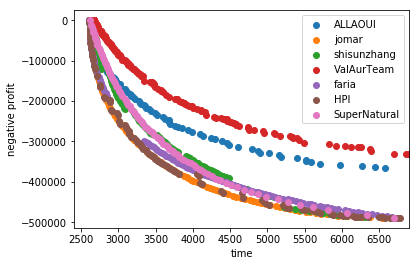

a280_n2790


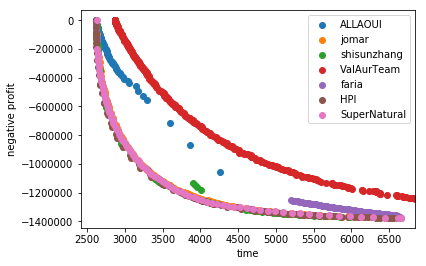

fnl4461_n4460


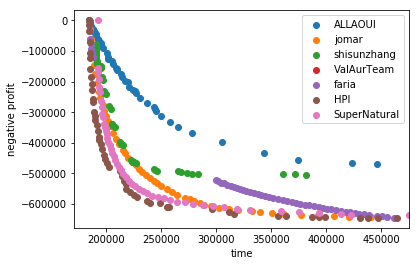

fnl4461_n22300


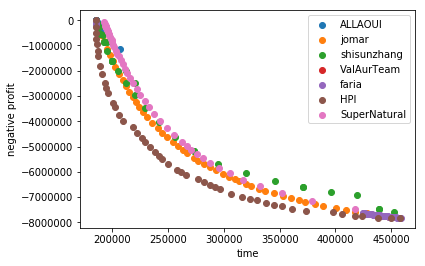

fnl4461_n44600


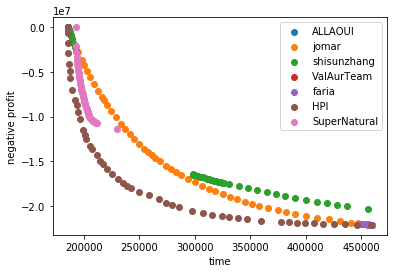

In [9]:
print("Plot the results. If points not shown there are not in the non-dominated region.")

for problem in problems[:6]:
    
    for participant in participants:
        _F = data[problem][participant]
        plt.scatter(_F[:,0], _F[:,1], label=participant)
        
    _all = np.row_stack([data[problem][participant] for participant in participants])
    I = fast_non_dominated_sort(_all)[0]
    _non_dom = _all[I]
    
    _min = _non_dom.min(axis=0)
    _max = _non_dom.max(axis=0)
    _range = _max - _min
        
    print("=" * 60)
    print(problem)
    print("=" * 60)
    plt.xlabel("time")
    plt.ylabel("negative profit")
    plt.xlim(_min[0] - 0.05 * _range[0], _max[0] + 0.05 * _range[0])
    plt.ylim(_min[1] - 0.05 * _range[1], _max[1] + 0.05 * _range[1])
    plt.legend()
    plt.savefig(problem + ".eps", format="eps")
    plt.show()
        

## Find the reference non-dominated set for each problem

For each problem we add the submissions to a new population and filter out the non-dominated solutions. Then, we take the minimum and the maximum of this set as the ideal and nadir point the normalize the results.

In [6]:

ideal_point = {}
nadir_point = {}
ndf = {}

for problem in problems[:6]:
    
    # the merged non-dominated solutions for the specific problem
    M = []
    for participant in participants:    
        _F = data[problem][participant]
        M.append(_F)
        
    M = np.vstack(M)    
    I = fast_non_dominated_sort(M)[0]
    M = M[I, :]
    
    ideal_point[problem] = np.min(M, axis=0)
    nadir_point[problem] = np.max(M, axis=0)
    ndf[problem] = M
    
    

In the following for each problem the non-dominated set of solutions is first normalized using the boundaries found before and then hypervolume is calculated.
If the reference point is larger than every solution submitted the hypervolume is zero.

In [7]:
results = []

for problem in problems[:6]:
    
    z = ideal_point[problem]
    z_nad = nadir_point[problem]
 
    for participant in participants:    
        _F = data[problem][participant]
        _N = normalize(_F, z, z_nad)
        _hv = Hypervolume(np.array([1,1])).calc(_N)
        results.append({'problem' : problem, 'participant' : participant, 'hv' : _hv})
        
df = pd.DataFrame(results, columns=["problem", "participant", "hv"])


In [8]:
for problem in problems[:6]:

    print("=" * 40)
    print(problem)
    print("=" * 40)
    
    _df = df[df["problem"] == problem].copy()
    _df.sort_values("hv", ascending=False, inplace=True)
    _df.reset_index(drop=True, inplace=True)
    print(_df)

a280_n279
     problem   participant        hv
0  a280_n279         jomar  0.937103
1  a280_n279           HPI  0.935400
2  a280_n279  SuperNatural  0.922676
3  a280_n279       ALLAOUI  0.879936
4  a280_n279   shisunzhang  0.869986
5  a280_n279         faria  0.741830
6  a280_n279    ValAurTeam  0.689979
a280_n1395
      problem   participant        hv
0  a280_n1395         jomar  0.819182
1  a280_n1395           HPI  0.812766
2  a280_n1395         faria  0.766621
3  a280_n1395   shisunzhang  0.757419
4  a280_n1395  SuperNatural  0.751835
5  a280_n1395       ALLAOUI  0.582044
6  a280_n1395    ValAurTeam  0.470855
a280_n2790
      problem   participant        hv
0  a280_n2790           HPI  0.881956
1  a280_n2790  SuperNatural  0.874713
2  a280_n2790         jomar  0.873150
3  a280_n2790   shisunzhang  0.861187
4  a280_n2790       ALLAOUI  0.621873
5  a280_n2790    ValAurTeam  0.588668
6  a280_n2790         faria  0.405476
fnl4461_n4460
         problem   participant        hv
0  fnl446

The data frame containts now all the results. Now we need to apply the ranking.

In [8]:
# the final ranking. And add zero points initially (sum is later taken anyway...)
ranking = []
for participant in participants:
    ranking.append({'participant': participant, 'points' : 0})


# one more time loop through problem wise
for problem in problems:
    
    _df = df[df["problem"] == problem].copy()
    
    # sort descending by hv
    _df.sort_values("hv", ascending=False, inplace=True)
    
    # 3 points for the 1st place
    first = _df.iloc[0]["participant"]
    ranking.append({'participant': first, 'points' : 3})
    
    # 2 points for the 2nd place
    second = _df.iloc[1]["participant"]
    ranking.append({'participant': second, 'points' : 2})
    
    # 1 point for the 3rd place
    third = _df.iloc[2]["participant"]
    ranking.append({'participant': third, 'points' : 1})

    
ranking = pd.DataFrame(ranking, columns=["participant", "points"])

# Leaderboard

Now let us some up the points for each problem and evaluate the winner!

In [15]:
ranking.groupby('participant').sum().sort_values("points", ascending=False)

,points
participant,
HPI,25
jomar,20
shisunzhang,7
ALLAOUI,1
faria,1
ValAurTeam,0


## Some additional Visualizations 

a280_n279
     problem  participant        hv
1  a280_n279        jomar  0.937103
5  a280_n279          HPI  0.935400
0  a280_n279      ALLAOUI  0.879936
2  a280_n279  shisunzhang  0.869986
4  a280_n279        faria  0.741830
3  a280_n279   ValAurTeam  0.689979


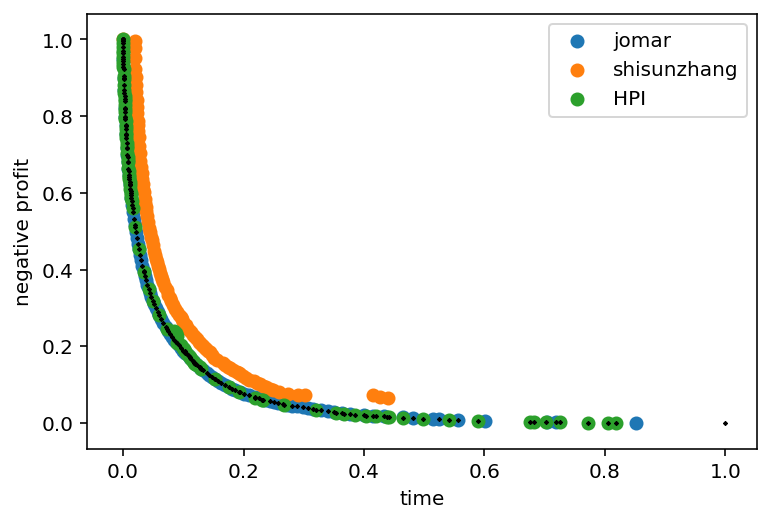

a280_n1395
       problem  participant        hv
7   a280_n1395        jomar  0.822271
11  a280_n1395          HPI  0.815993
10  a280_n1395        faria  0.770548
8   a280_n1395  shisunzhang  0.761535
6   a280_n1395      ALLAOUI  0.584886
9   a280_n1395   ValAurTeam  0.474426


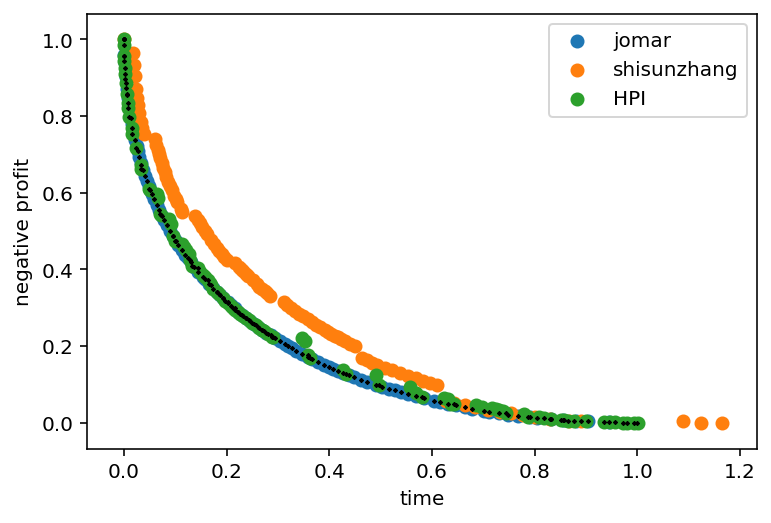

a280_n2790
       problem  participant        hv
17  a280_n2790          HPI  0.881956
13  a280_n2790        jomar  0.873150
14  a280_n2790  shisunzhang  0.861187
12  a280_n2790      ALLAOUI  0.621873
15  a280_n2790   ValAurTeam  0.588668
16  a280_n2790        faria  0.405476


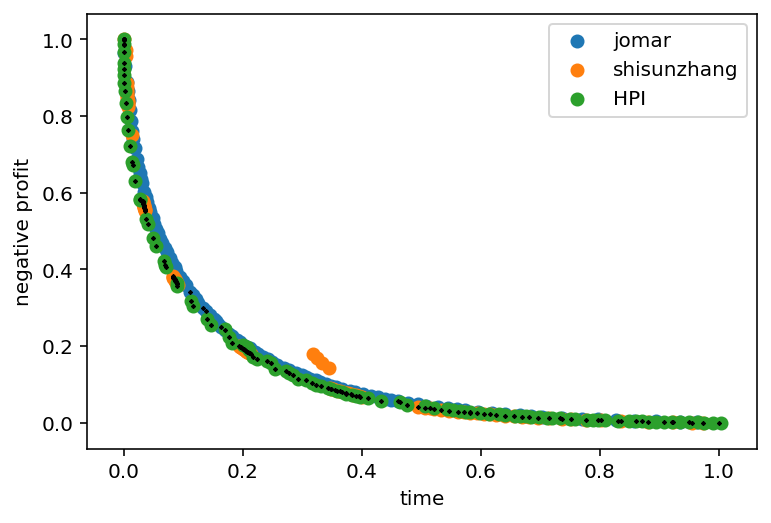

fnl4461_n4460
          problem  participant        hv
23  fnl4461_n4460          HPI  0.928875
19  fnl4461_n4460        jomar  0.873717
20  fnl4461_n4460  shisunzhang  0.720772
22  fnl4461_n4460        faria  0.616963
18  fnl4461_n4460      ALLAOUI  0.558061
21  fnl4461_n4460   ValAurTeam  0.000000


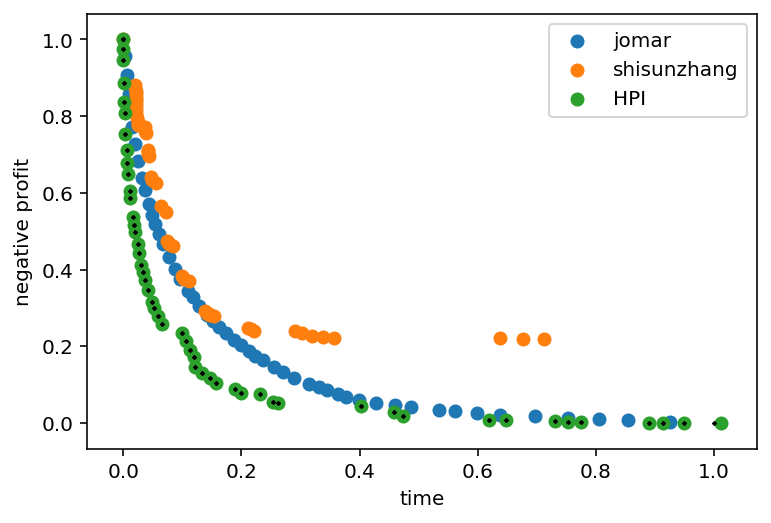

fnl4461_n22300
           problem  participant        hv
29  fnl4461_n22300          HPI  0.814533
25  fnl4461_n22300        jomar  0.733595
26  fnl4461_n22300  shisunzhang  0.671055
28  fnl4461_n22300        faria  0.142984
24  fnl4461_n22300      ALLAOUI  0.139426
27  fnl4461_n22300   ValAurTeam  0.000000


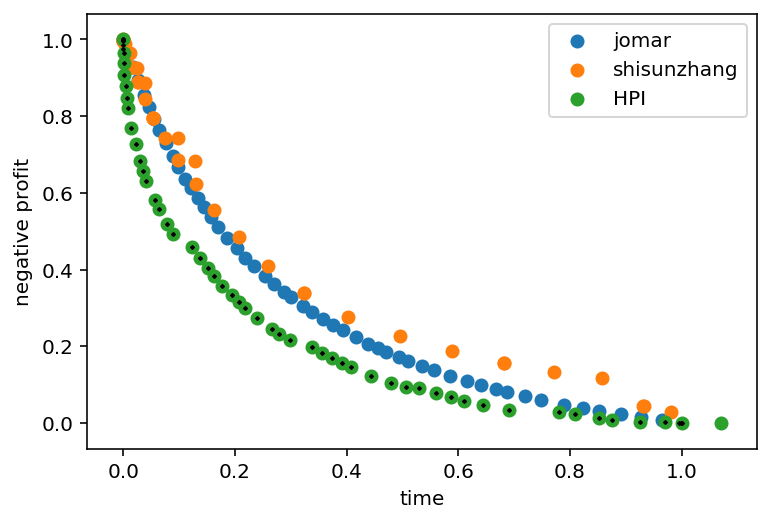

fnl4461_n44600
           problem  participant        hv
35  fnl4461_n44600          HPI  0.877274
31  fnl4461_n44600        jomar  0.735329
32  fnl4461_n44600  shisunzhang  0.540689
34  fnl4461_n44600        faria  0.039143
30  fnl4461_n44600      ALLAOUI  0.009693
33  fnl4461_n44600   ValAurTeam  0.000000


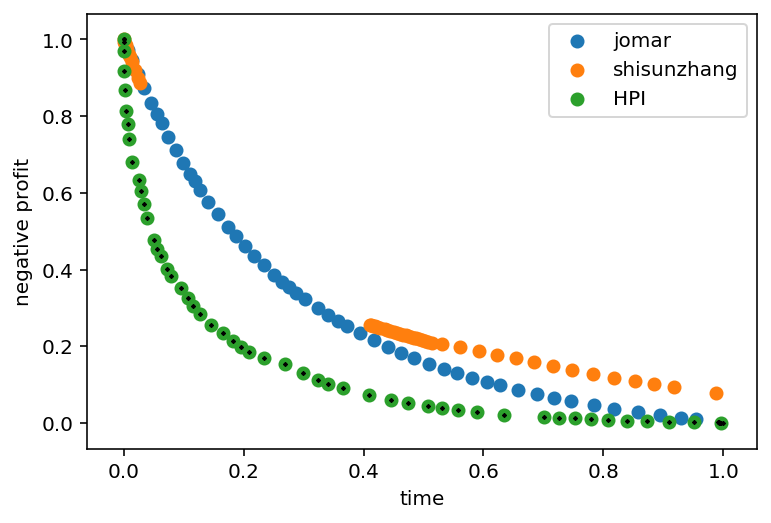

pla33810_n33809
            problem  participant        hv
41  pla33810_n33809          HPI  0.892964
37  pla33810_n33809        jomar  0.727337
38  pla33810_n33809  shisunzhang  0.498648
40  pla33810_n33809        faria  0.114619
36  pla33810_n33809      ALLAOUI  0.090585
39  pla33810_n33809   ValAurTeam  0.000000


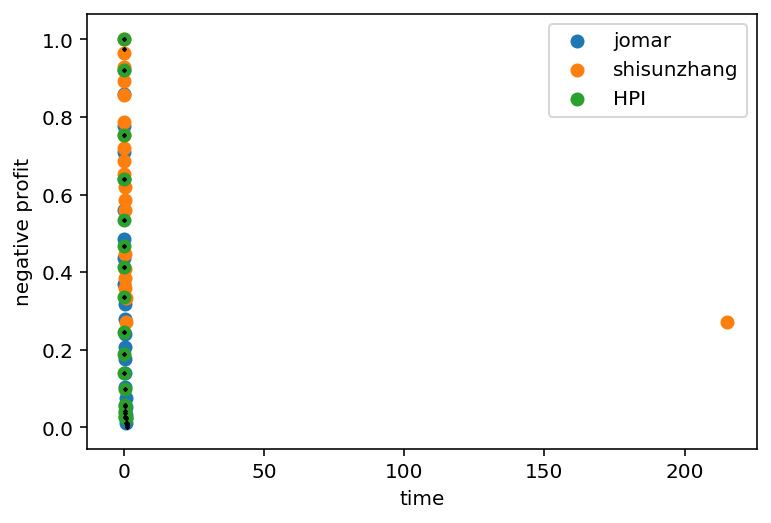

pla33810_n169045
             problem  participant        hv
47  pla33810_n169045          HPI  0.786283
43  pla33810_n169045        jomar  0.699620
44  pla33810_n169045  shisunzhang  0.022419
42  pla33810_n169045      ALLAOUI  0.007377
46  pla33810_n169045        faria  0.003688
45  pla33810_n169045   ValAurTeam  0.000000


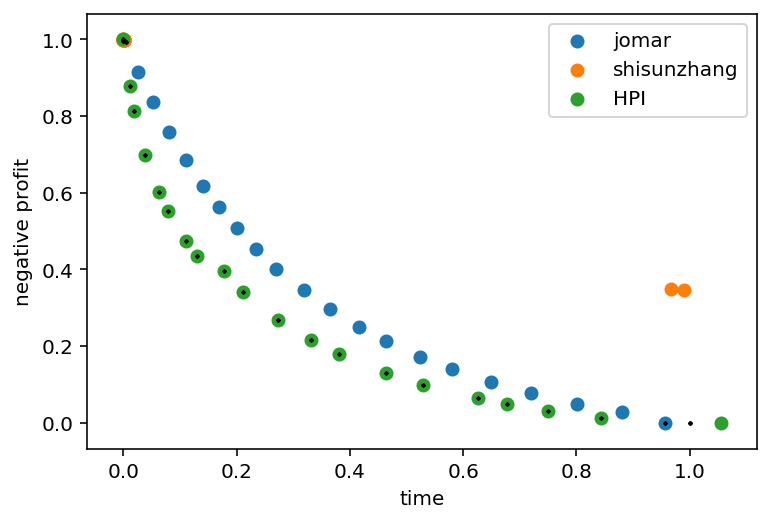

pla33810_n338090
             problem  participant        hv
53  pla33810_n338090          HPI  0.856519
49  pla33810_n338090        jomar  0.706929
50  pla33810_n338090  shisunzhang  0.049184
48  pla33810_n338090      ALLAOUI  0.001853
52  pla33810_n338090        faria  0.000861
51  pla33810_n338090   ValAurTeam  0.000000


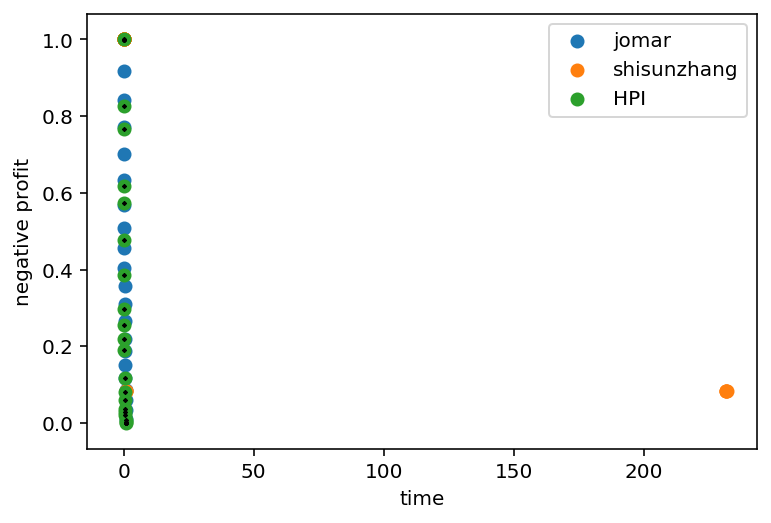

In [16]:

do_normalize = True

for problem in problems:
    
    for participant in ["jomar", "shisunzhang", "HPI"]:    
        _F = data[problem][participant]
        if do_normalize:
            _F = normalize(_F, ideal_point[problem], nadir_point[problem])
            
        plt.scatter(_F[:,0], _F[:,1], label=participant)
        
    _ndf = ndf[problem]
    if do_normalize:
        _ndf = normalize(_ndf, ideal_point[problem], nadir_point[problem])
    
    plt.scatter(_ndf[:,0], _ndf[:,1], marker='x', s=2, color='black')
        
    print("=" * 60)
    print(problem)
    print("=" * 60)
    
    _df = df[df["problem"] == problem].copy()
    _df.sort_values("hv", ascending=False, inplace=True)
    _df.reset_index(drop=True)
    print(_df)

    plt.xlabel("time")
    plt.ylabel("negative profit")
    plt.legend()
    plt.show()
        

## Leaderboard as HTML

In [17]:




standalone = True
if standalone:
    print("<script src='https://code.jquery.com/jquery-3.2.1.slim.min.js' integrity='sha384-KJ3o2DKtIkvYIK3UENzmM7KCkRr/rE9/Qpg6aAZGJwFDMVNA/GpGFF93hXpG5KkN' crossorigin='anonymous'></script>")
    print("<script src='https://cdnjs.cloudflare.com/ajax/libs/popper.js/1.12.9/umd/popper.min.js' integrity='sha384-ApNbgh9B+Y1QKtv3Rn7W3mgPxhU9K/ScQsAP7hUibX39j7fakFPskvXusvfa0b4Q' crossorigin='anonymous'></script>")
    print("<script src='https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/js/bootstrap.min.js' integrity='sha384-JZR6Spejh4U02d8jOt6vLEHfe/JQGiRRSQQxSfFWpi1MquVdAyjUar5+76PVCmYl' crossorigin='anonymous'></script>")

print("<div class='row'><div class='w-50'>")
print("<table class='table'>")
print("<tr><th>Problem</th><th>Team</th><th>Hypervolume</th><th>Estimated Ideal Point</th><th>Estimated Nadir Point</th></tr>")

for problem in problems:
    
    _df = df[df["problem"] == problem].copy()
    _df.sort_values("hv", ascending=False, inplace=True)
    _df.reset_index(drop=True)
    
    first = True
    for i, e in _df.iterrows():
        
        problem, team, hv = e.values
        
        if first:
            
            s_row_span = "<th rowspan='%s'>%s</th>"
            
            s_problem = s_row_span % (len(_df), problem)
            s_ideal = s_row_span % (len(_df), "(%s, %s)" % (round(ideal_point[problem][0]), round(ideal_point[problem][1])))
            s_nadir = s_row_span % (len(_df), "(%s, %s)" % (round(nadir_point[problem][0]), round(nadir_point[problem][1])))
            
            print("<tr>%s <th>%s</th> <th>%s</th> %s %s  </tr>" 
                  % (s_problem, team, round(hv,4), s_ideal, s_nadir))
        else:
            print("<tr><th>%s</th><th>%s</th></tr>" % (team, round(hv,4)))
        
            
        first = False
        
    print()
    
    
print("<table>")
print("</div></div>")

<script src='https://code.jquery.com/jquery-3.2.1.slim.min.js' integrity='sha384-KJ3o2DKtIkvYIK3UENzmM7KCkRr/rE9/Qpg6aAZGJwFDMVNA/GpGFF93hXpG5KkN' crossorigin='anonymous'></script>
<script src='https://cdnjs.cloudflare.com/ajax/libs/popper.js/1.12.9/umd/popper.min.js' integrity='sha384-ApNbgh9B+Y1QKtv3Rn7W3mgPxhU9K/ScQsAP7hUibX39j7fakFPskvXusvfa0b4Q' crossorigin='anonymous'></script>
<script src='https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/js/bootstrap.min.js' integrity='sha384-JZR6Spejh4U02d8jOt6vLEHfe/JQGiRRSQQxSfFWpi1MquVdAyjUar5+76PVCmYl' crossorigin='anonymous'></script>
<div class='row'><div class='w-50'>
<table class='table'>
<tr><th>Problem</th><th>Team</th><th>Hypervolume</th><th>Estimated Ideal Point</th><th>Estimated Nadir Point</th></tr>
<tr><th rowspan='6'>a280_n279</th> <th>jomar</th> <th>0.9371</th> <th rowspan='6'>(2613.0, -42036.0)</th> <th rowspan='6'>(7856.0, -0.0)</th>  </tr>
<tr><th>HPI</th><th>0.9354</th></tr>
<tr><th>ALLAOUI</th><th>0.8799</th></tr>
<tr><th>s

In [20]:
_ranking = ranking.groupby('participant').sum().sort_values("points", ascending=False)

standalone = True
if standalone:
    print("<script src='https://code.jquery.com/jquery-3.2.1.slim.min.js' integrity='sha384-KJ3o2DKtIkvYIK3UENzmM7KCkRr/rE9/Qpg6aAZGJwFDMVNA/GpGFF93hXpG5KkN' crossorigin='anonymous'></script>")
    print("<script src='https://cdnjs.cloudflare.com/ajax/libs/popper.js/1.12.9/umd/popper.min.js' integrity='sha384-ApNbgh9B+Y1QKtv3Rn7W3mgPxhU9K/ScQsAP7hUibX39j7fakFPskvXusvfa0b4Q' crossorigin='anonymous'></script>")
    print("<script src='https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/js/bootstrap.min.js' integrity='sha384-JZR6Spejh4U02d8jOt6vLEHfe/JQGiRRSQQxSfFWpi1MquVdAyjUar5+76PVCmYl' crossorigin='anonymous'></script>")


print("<div class='row'><div class='w-50'>")
print("<table class='table'>")
print("<tr><th>Rank</th><th>Team</th><th>Points</th></tr>")


counter = 0
for i, e in _ranking.iterrows():
    print("<tr><th>%s</th><th>%s</th><th>%s</th></tr>" % (counter+1, i, e[0]))
    counter += 1

    
print("<table>")
print("</div></div>")


<script src='https://code.jquery.com/jquery-3.2.1.slim.min.js' integrity='sha384-KJ3o2DKtIkvYIK3UENzmM7KCkRr/rE9/Qpg6aAZGJwFDMVNA/GpGFF93hXpG5KkN' crossorigin='anonymous'></script>
<script src='https://cdnjs.cloudflare.com/ajax/libs/popper.js/1.12.9/umd/popper.min.js' integrity='sha384-ApNbgh9B+Y1QKtv3Rn7W3mgPxhU9K/ScQsAP7hUibX39j7fakFPskvXusvfa0b4Q' crossorigin='anonymous'></script>
<script src='https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/js/bootstrap.min.js' integrity='sha384-JZR6Spejh4U02d8jOt6vLEHfe/JQGiRRSQQxSfFWpi1MquVdAyjUar5+76PVCmYl' crossorigin='anonymous'></script>
<div class='row'><div class='w-50'>
<table class='table'>
<tr><th>Rank</th><th>Team</th><th>Points</th></tr>
<tr><th>1</th><th>HPI</th><th>25</th></tr>
<tr><th>2</th><th>jomar</th><th>20</th></tr>
<tr><th>3</th><th>shisunzhang</th><th>7</th></tr>
<tr><th>4</th><th>ALLAOUI</th><th>1</th></tr>
<tr><th>5</th><th>faria</th><th>1</th></tr>
<tr><th>6</th><th>ValAurTeam</th><th>0</th></tr>
<table>
</div></div>
